In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')

# 1. 삼성전자

# 데이터 불러오기

In [2]:
samsung_filepath = os.getenv('HOME')+'/aiffel/exp14/stock_prediction/data/005930.KS.csv' 
ss_df = pd.read_csv(samsung_filepath) 
ss_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


# Date를 인덱스로 설정

In [3]:
ss_df = pd.read_csv(samsung_filepath, index_col='Date', parse_dates=True)
ss_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


# 종가인 Close로 시리즈 생성

In [4]:
ss_ts = ss_df['Close']
print(type(ss_ts))
ss_ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# 결측치 처리

In [5]:
ss_ts=ss_ts.interpolate(method='time')
ss_ts[ss_ts.isna()]

Series([], Name: Close, dtype: float64)

# 주가 확인

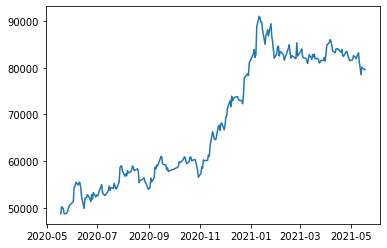

In [6]:
plt.plot(ss_ts)

# 로그 처리

In [7]:
ss_ts_log = np.log(ss_ts)

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 원본시계열, 이동평균, 이동표준편차 시각화

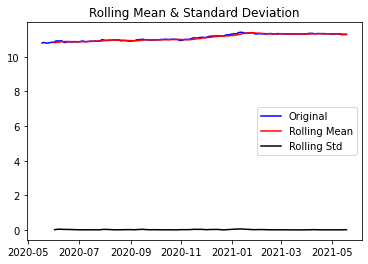

In [9]:
plot_rolling_statistics(ss_ts_log, window=12)

In [10]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# 데이터 정상성 확인

In [11]:
augmented_dickey_fuller_test(ss_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


# 시계열 분해

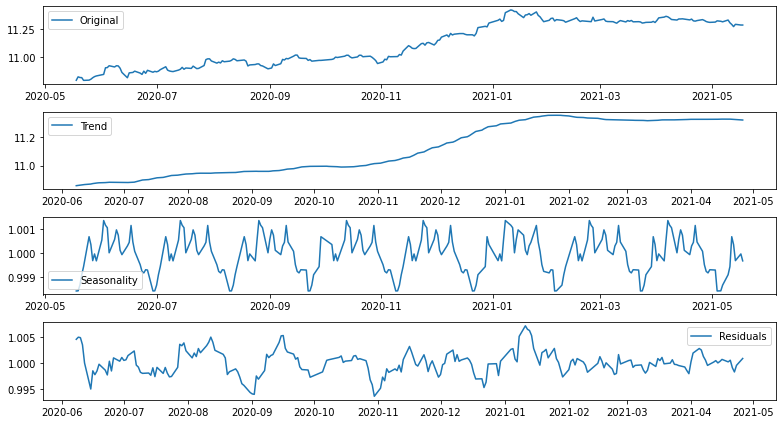

In [12]:
decomposition = seasonal_decompose(ss_ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ss_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인

In [13]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# ACF 및 PACF 시각화

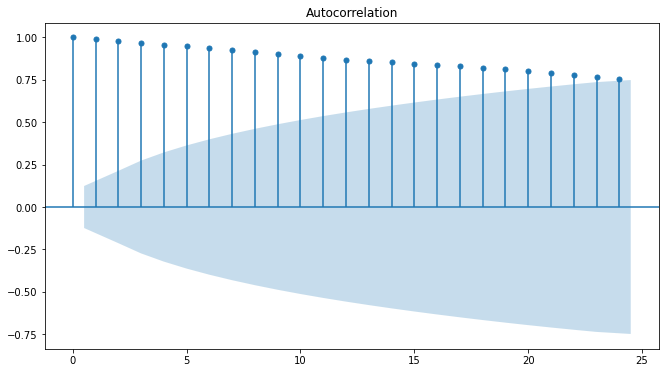

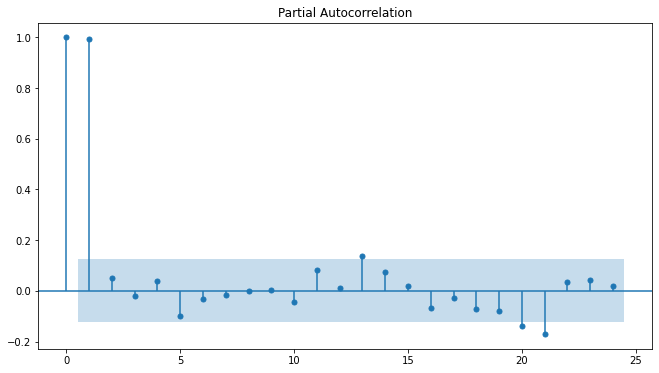

In [14]:
plot_acf(ss_ts_log)
plot_pacf(ss_ts_log)
plt.show()

# p = 1, q = 0

# 차분

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


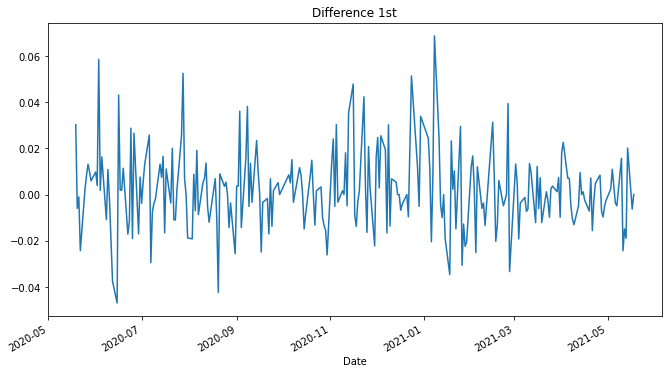

In [15]:
diff_1 = ss_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


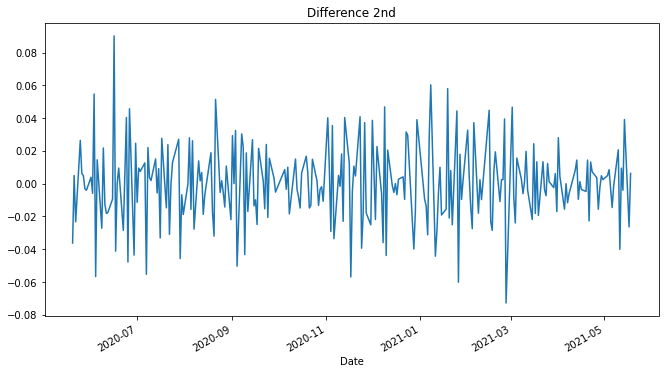

In [16]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# d = 1

# 학습 데이터와 테스트 데이터 분리

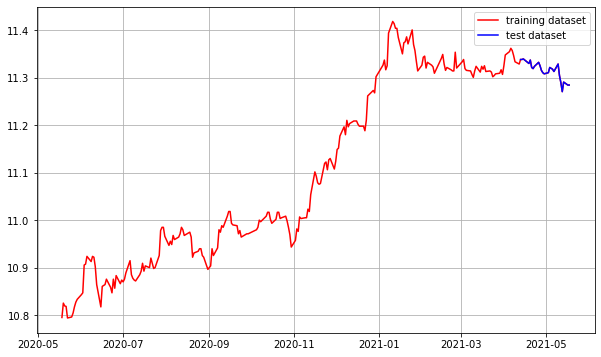

In [17]:
ss_train_data, ss_test_data = ss_ts_log[:int(len(ss_ts_log)*0.9)], ss_ts_log[int(len(ss_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ss_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ss_test_data, c='b', label='test dataset')
plt.legend()

# ARIMA(1, 1, 0)

In [18]:
model = ARIMA(ss_train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 11 Nov 2021   AIC                          -1164.792
Time:                        05:36:25   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

# 예측 결과 시각화

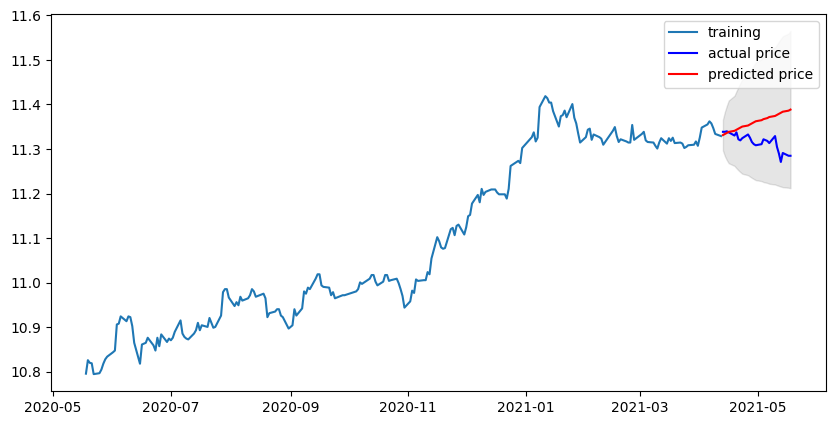

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(ss_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=ss_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=ss_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=ss_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(ss_train_data, label='training')
plt.plot(ss_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [23]:
mse = mean_squared_error(np.exp(ss_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(ss_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(ss_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(ss_test_data))/np.abs(np.exp(ss_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


***

# 2. 애플

# 데이터 불러오기

In [26]:
AAPL_filepath = os.getenv('HOME')+'/aiffel/exp14/stock_prediction/data/AAPL.csv' 
AAPL_df = pd.read_csv(AAPL_filepath) 
AAPL_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-11,117.190002,119.629997,116.440002,119.489998,118.757881,112295000
1,2020-11-12,119.620003,120.529999,118.570000,119.209999,118.479599,103162300
2,2020-11-13,119.440002,119.669998,117.870003,119.260002,118.529297,81581900
3,2020-11-16,118.919998,120.989998,118.150002,120.300003,119.562920,91183000
4,2020-11-17,119.550003,120.669998,118.959999,119.389999,118.658493,74271000


# Date를 인덱스로 설정

In [27]:
AAPL_df = pd.read_csv(AAPL_filepath, index_col='Date', parse_dates=True)
AAPL_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-11,117.190002,119.629997,116.440002,119.489998,118.757881,112295000
2020-11-12,119.620003,120.529999,118.570000,119.209999,118.479599,103162300
2020-11-13,119.440002,119.669998,117.870003,119.260002,118.529297,81581900
2020-11-16,118.919998,120.989998,118.150002,120.300003,119.562920,91183000
2020-11-17,119.550003,120.669998,118.959999,119.389999,118.658493,74271000


# 종가인 Close로 시리즈 생성

In [28]:
AAPL_ts = AAPL_df['Close']
print(type(AAPL_ts))
AAPL_ts.head()

<class 'pandas.core.series.Series'>


Date
2020-11-11    119.489998
2020-11-12    119.209999
2020-11-13    119.260002
2020-11-16    120.300003
2020-11-17    119.389999
Name: Close, dtype: float64

# 결측치 처리

In [29]:
AAPL_ts=AAPL_ts.interpolate(method='time')
AAPL_ts[AAPL_ts.isna()]

Series([], Name: Close, dtype: float64)

# 주가 확인

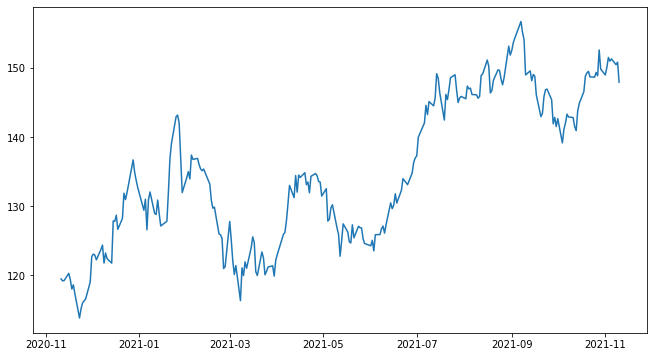

In [30]:
plt.plot(AAPL_ts)

# 로그 처리

In [31]:
AAPL_ts_log = np.log(AAPL_ts)

# 원본시계열, 이동평균, 이동표준편차 시각화

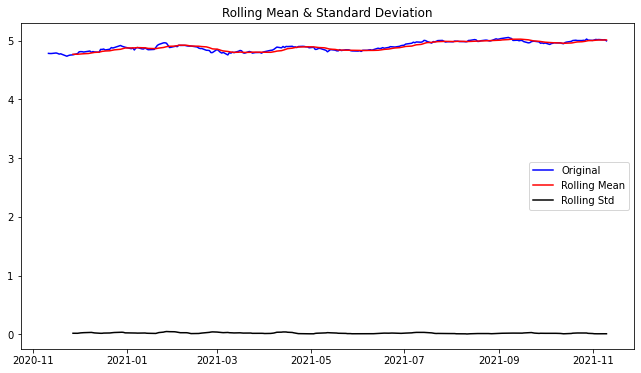

In [32]:
plot_rolling_statistics(AAPL_ts_log, window=12)

# 데이터 정상성 확인

In [33]:
augmented_dickey_fuller_test(AAPL_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.688424
p-value                          0.437086
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


# 시계열 분해

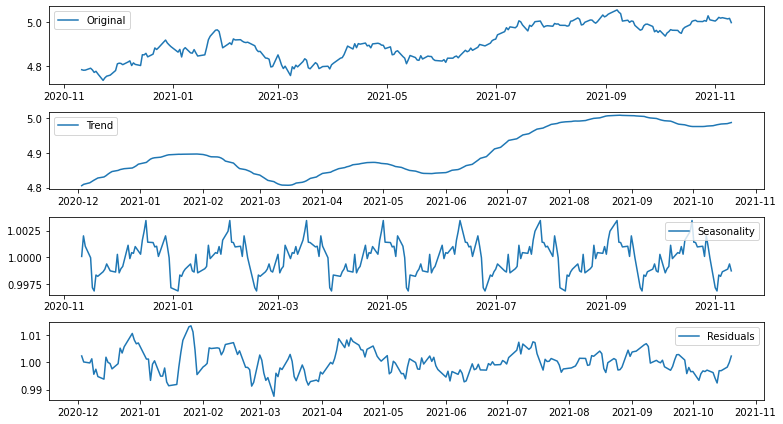

In [34]:
decomposition = seasonal_decompose(AAPL_ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(AAPL_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인

In [35]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.364862
p-value                          0.000004
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


# ACF 및 PACF 시각화

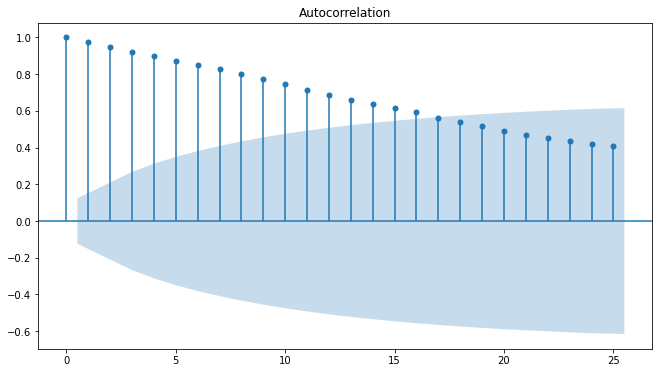

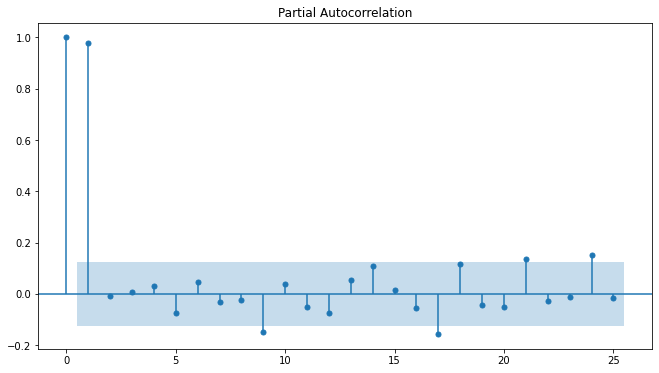

In [36]:
plot_acf(AAPL_ts_log)
plot_pacf(AAPL_ts_log)
plt.show()

# p = 1, q = 0

# 차분

Results of Dickey-Fuller Test:
Test Statistic                -1.648824e+01
p-value                        2.204688e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


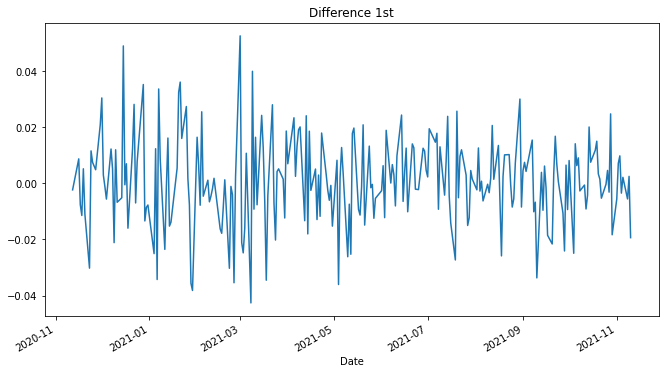

In [37]:
diff_1 = AAPL_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.648081e+00
p-value                        1.819963e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


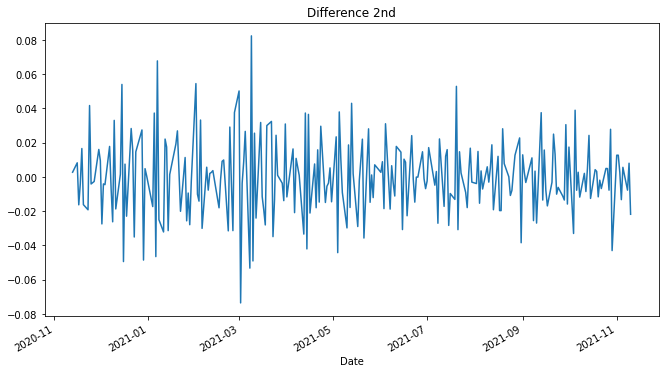

In [38]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# d = 1

# 학습 데이터와 테스트 데이터 분리

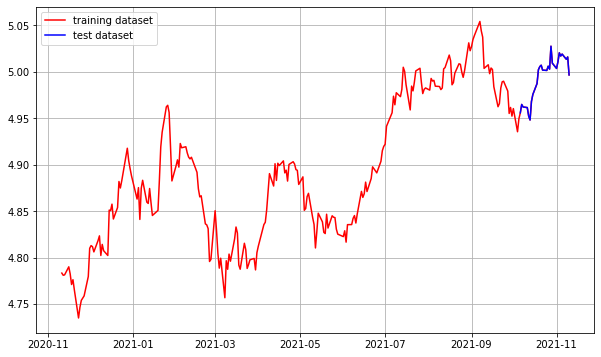

In [39]:
AAPL_train_data, AAPL_test_data = AAPL_ts_log[:int(len(AAPL_ts_log)*0.9)], AAPL_ts_log[int(len(AAPL_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(AAPL_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(AAPL_test_data, c='b', label='test dataset')
plt.legend()

# ARIMA(1, 1, 0)

In [40]:
model = ARIMA(AAPL_train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 610.839
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 11 Nov 2021   AIC                          -1215.678
Time:                        06:00:08   BIC                          -1205.429
Sample:                             1   HQIC                         -1211.541
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.001      0.724      0.469      -0.001       0.003
ar.L1.D.Close    -0.0498      0.067     -0.749      0.454      -0.180       0.081
                                    Root

# 예측 결과 시각화

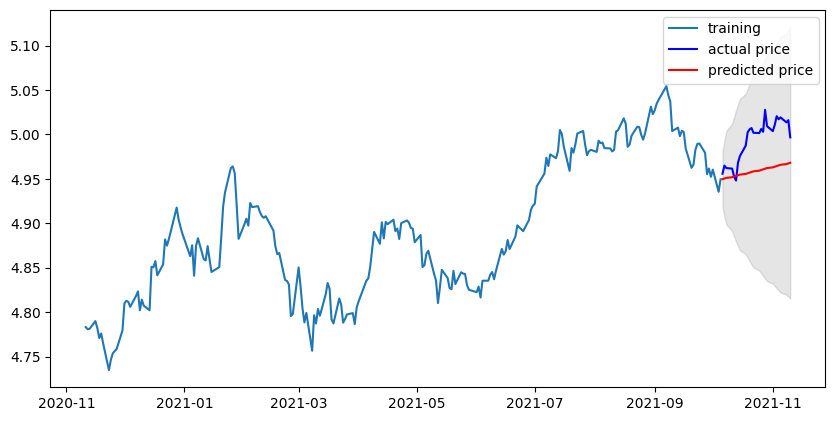

In [41]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(AAPL_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=AAPL_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=AAPL_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=AAPL_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(AAPL_train_data, label='training')
plt.plot(AAPL_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [48]:
mse = mean_squared_error(np.exp(AAPL_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(AAPL_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(AAPL_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(AAPL_test_data))/np.abs(np.exp(AAPL_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  33.95155230300995
MAE:  5.157668431483192
RMSE:  5.8267960581274805
MAPE: 3.45%


***

# 3. 마이크로소프트

# 데이터 불러오기

In [49]:
MSFT_filepath = os.getenv('HOME')+'/aiffel/exp14/stock_prediction/data/MSFT.csv' 
MSFT_df = pd.read_csv(MSFT_filepath) 
MSFT_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-11,212.389999,218.039993,212.199997,216.550003,214.581009,29440800
1,2020-11-12,217.210007,219.110001,214.460007,215.440002,213.481094,21593900
2,2020-11-13,216.360001,217.419998,214.160004,216.509995,214.541367,18621100
3,2020-11-16,214.869995,217.740005,214.520004,217.229996,215.254822,24953300
4,2020-11-17,216.100006,217.679993,214.080002,214.460007,212.510010,24154100


# Date를 인덱스로 설정

In [50]:
MSFT_df = pd.read_csv(MSFT_filepath, index_col='Date', parse_dates=True)
MSFT_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-11,212.389999,218.039993,212.199997,216.550003,214.581009,29440800
2020-11-12,217.210007,219.110001,214.460007,215.440002,213.481094,21593900
2020-11-13,216.360001,217.419998,214.160004,216.509995,214.541367,18621100
2020-11-16,214.869995,217.740005,214.520004,217.229996,215.254822,24953300
2020-11-17,216.100006,217.679993,214.080002,214.460007,212.510010,24154100


# 종가인 Close로 시리즈 생성

In [51]:
MSFT_ts = MSFT_df['Close']
print(type(MSFT_ts))
MSFT_ts.head()

<class 'pandas.core.series.Series'>


Date
2020-11-11    216.550003
2020-11-12    215.440002
2020-11-13    216.509995
2020-11-16    217.229996
2020-11-17    214.460007
Name: Close, dtype: float64

# 결측치 처리

In [52]:
MSFT_ts=MSFT_ts.interpolate(method='time')
MSFT_ts[MSFT_ts.isna()]

Series([], Name: Close, dtype: float64)

# 주가 확인

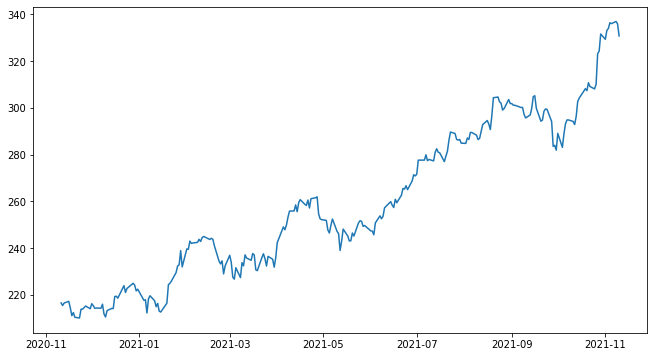

In [53]:
plt.plot(MSFT_ts)

# 로그 처리

In [54]:
MSFT_ts_log = np.log(MSFT_ts)

# 원본시계열, 이동평균, 이동표준편차 시각화

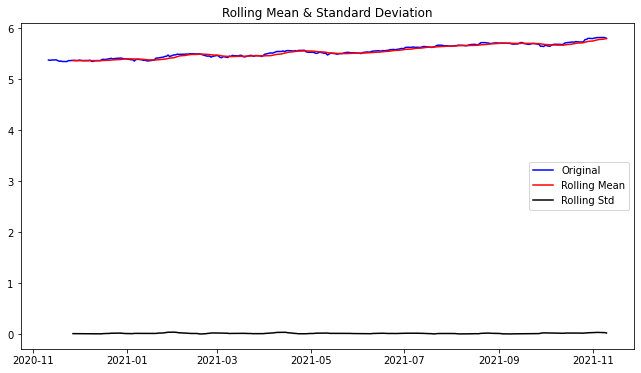

In [55]:
plot_rolling_statistics(MSFT_ts_log, window=12)

# 데이터 정상성 확인

In [56]:
augmented_dickey_fuller_test(MSFT_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.125519
p-value                          0.946837
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


# 시계열 분해

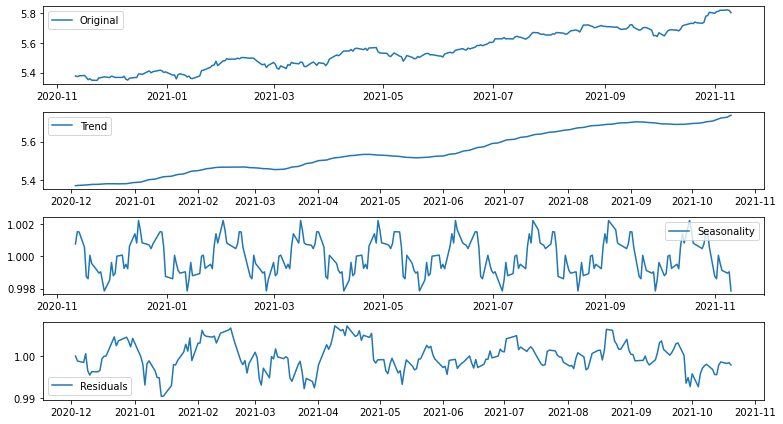

In [57]:
decomposition = seasonal_decompose(MSFT_ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(MSFT_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인

In [58]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.117393
p-value                          0.000013
#Lags Used                       8.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


# ACF 및 PACF 시각화

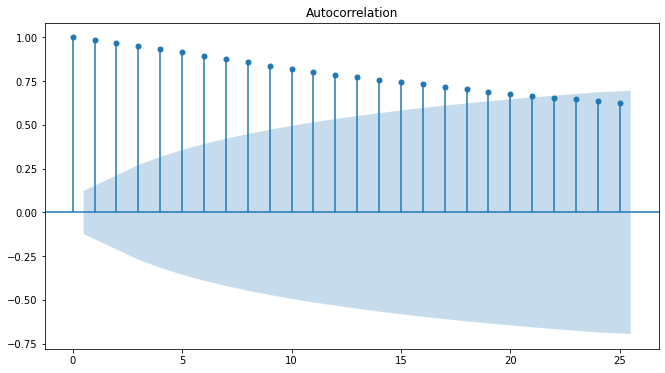

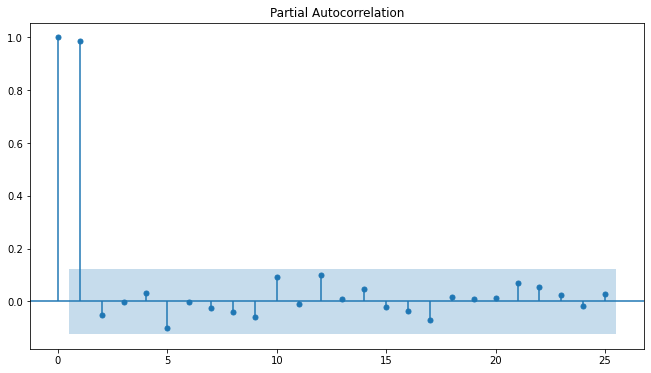

In [59]:
plot_acf(MSFT_ts_log)
plot_pacf(MSFT_ts_log)
plt.show()

# p = 1, q = 0

# 차분

Results of Dickey-Fuller Test:
Test Statistic                -7.526789e+00
p-value                        3.666783e-11
#Lags Used                     3.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


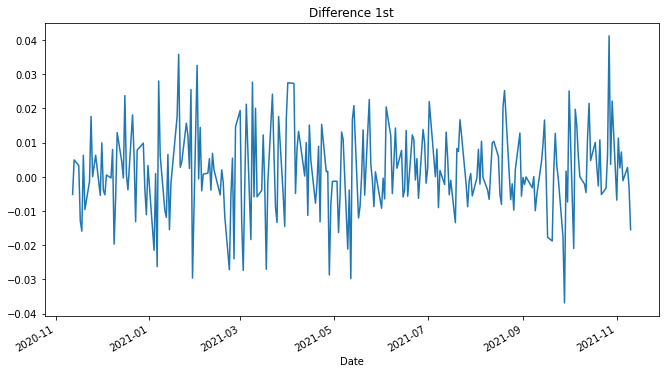

In [60]:
diff_1 = MSFT_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.101628e+01
p-value                        6.145356e-20
#Lags Used                     6.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


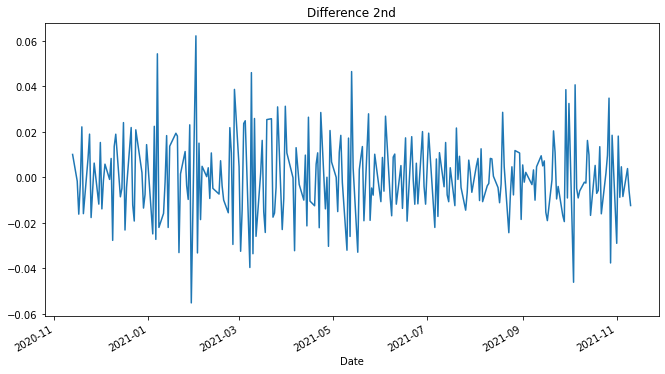

In [61]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# d = 2

# 학습 데이터와 테스트 데이터 분리

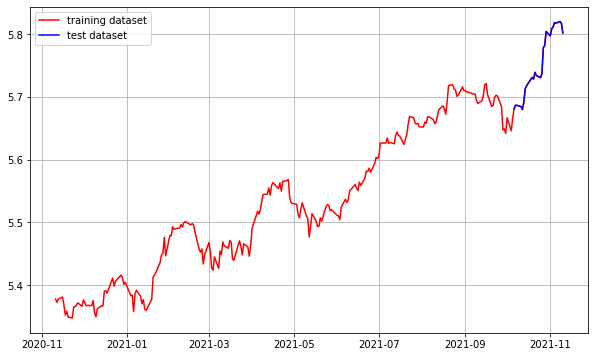

In [62]:
MSFT_train_data, MSFT_test_data = MSFT_ts_log[:int(len(MSFT_ts_log)*0.9)], MSFT_ts_log[int(len(MSFT_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(MSFT_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(MSFT_test_data, c='b', label='test dataset')
plt.legend()

# ARIMA(1, 1, 0)

In [63]:
model = ARIMA(MSFT_train_data, order=(1, 2, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  224
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 610.482
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 11 Nov 2021   AIC                          -1214.965
Time:                        06:05:58   BIC                          -1204.730
Sample:                             2   HQIC                         -1210.834
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.562e-05      0.001      0.050      0.960      -0.001       0.001
ar.L1.D2.Close    -0.5006      0.058     -8.564      0.000      -0.615      -0.386
                                    

# 예측 결과 시각화

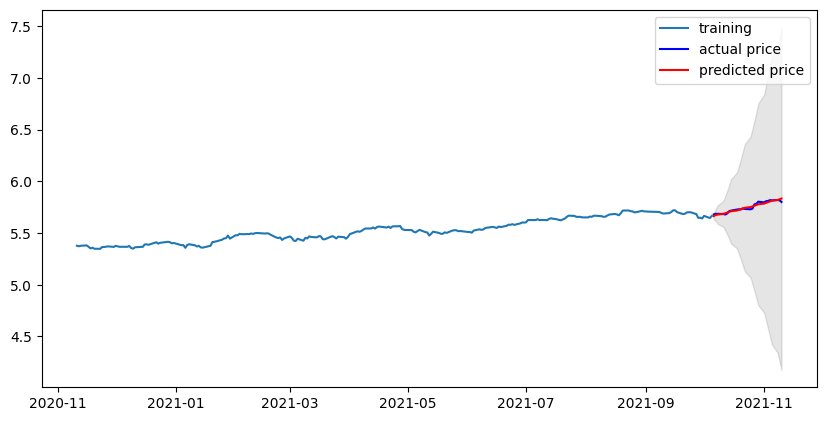

In [64]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(MSFT_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=MSFT_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=MSFT_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=MSFT_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(MSFT_train_data, label='training')
plt.plot(MSFT_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [65]:
mse = mean_squared_error(np.exp(MSFT_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(MSFT_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(MSFT_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(MSFT_test_data))/np.abs(np.exp(MSFT_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18.693374087904854
MAE:  3.548800550097859
RMSE:  4.3235834776149344
MAPE: 1.12%


***

# 4. 테슬라

# 데이터 불러오기

In [66]:
TSLA_filepath = os.getenv('HOME')+'/aiffel/exp14/stock_prediction/data/TSLA.csv' 
TSLA_df = pd.read_csv(TSLA_filepath) 
TSLA_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-11,416.450012,418.700012,410.579987,417.130005,417.130005,17357700
1,2020-11-12,415.049988,423.000000,409.519989,411.760010,411.760010,19855100
2,2020-11-13,410.850006,412.529999,401.660004,408.500000,408.500000,19771100
3,2020-11-16,408.929993,412.450012,404.089996,408.089996,408.089996,26838600
4,2020-11-17,460.170013,462.000000,433.010010,441.609985,441.609985,61188300


# Date를 인덱스로 설정

In [67]:
TSLA_df = pd.read_csv(TSLA_filepath, index_col='Date', parse_dates=True)
TSLA_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-11,416.450012,418.700012,410.579987,417.130005,417.130005,17357700
2020-11-12,415.049988,423.000000,409.519989,411.760010,411.760010,19855100
2020-11-13,410.850006,412.529999,401.660004,408.500000,408.500000,19771100
2020-11-16,408.929993,412.450012,404.089996,408.089996,408.089996,26838600
2020-11-17,460.170013,462.000000,433.010010,441.609985,441.609985,61188300


# 종가인 Close로 시리즈 생성

In [68]:
TSLA_ts = TSLA_df['Close']
print(type(TSLA_ts))
TSLA_ts.head()

<class 'pandas.core.series.Series'>


Date
2020-11-11    417.130005
2020-11-12    411.760010
2020-11-13    408.500000
2020-11-16    408.089996
2020-11-17    441.609985
Name: Close, dtype: float64

# 결측치 처리

In [69]:
TSLA_ts=TSLA_ts.interpolate(method='time')
TSLA_ts[TSLA_ts.isna()]

Series([], Name: Close, dtype: float64)

# 주가 확인

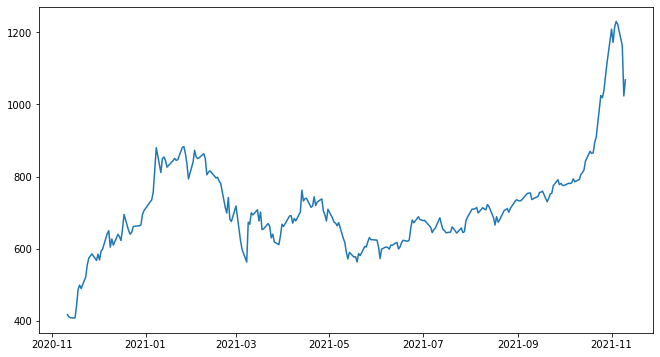

In [70]:
plt.plot(TSLA_ts)

# 로그 처리

In [71]:
TSLA_ts_log = np.log(TSLA_ts)

# 원본시계열, 이동평균, 이동표준편차 시각화

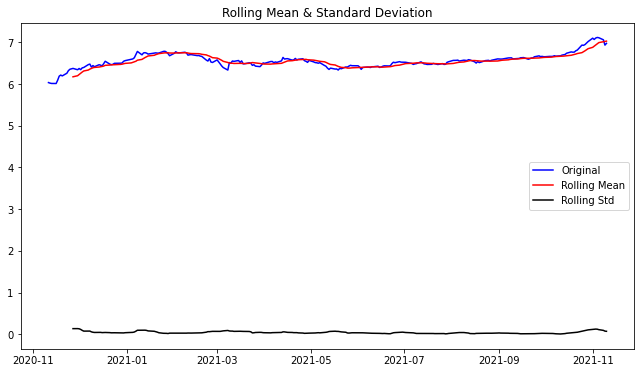

In [72]:
plot_rolling_statistics(TSLA_ts_log, window=12)

# 데이터 정상성 확인

In [73]:
augmented_dickey_fuller_test(TSLA_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.132496
p-value                          0.231650
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


# 시계열 분해

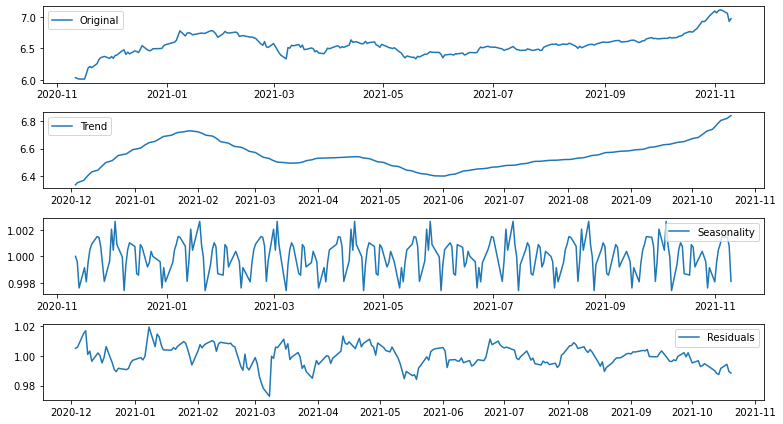

In [74]:
decomposition = seasonal_decompose(TSLA_ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(TSLA_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인

In [75]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.206150
p-value                          0.000009
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


# ACF 및 PACF 시각화

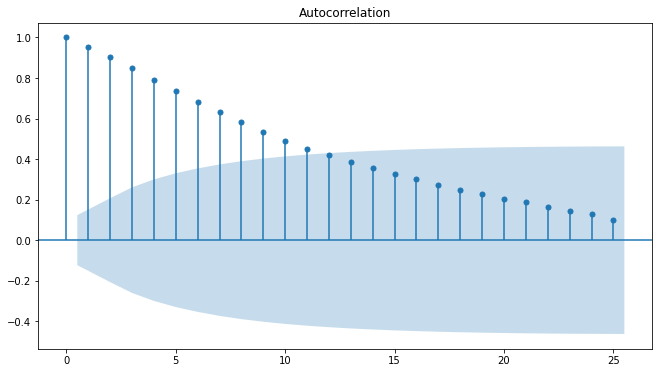

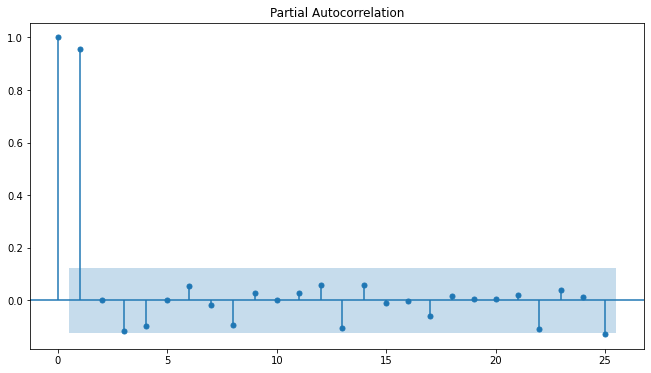

In [76]:
plot_acf(TSLA_ts_log)
plot_pacf(TSLA_ts_log)
plt.show()

# p = 1, q = 0

# 차분

Results of Dickey-Fuller Test:
Test Statistic                -1.630466e+01
p-value                        3.240448e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


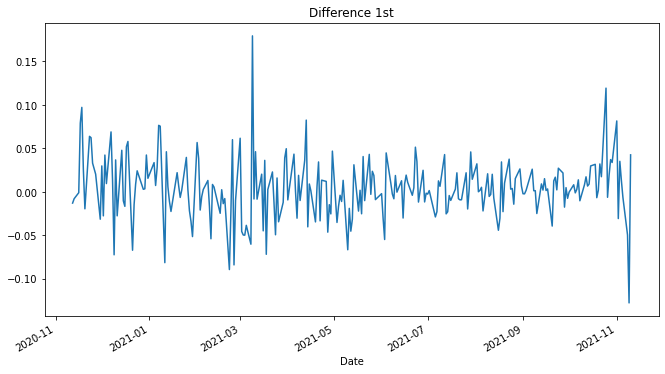

In [77]:
diff_1 = TSLA_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.312671e+00
p-value                        3.206095e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


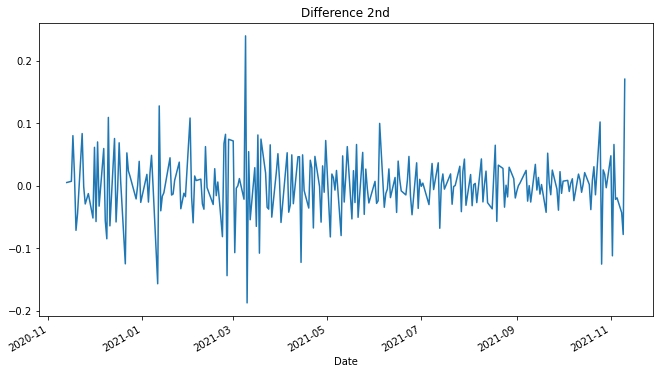

In [78]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# d = 1

# 학습 데이터와 테스트 데이터 분리

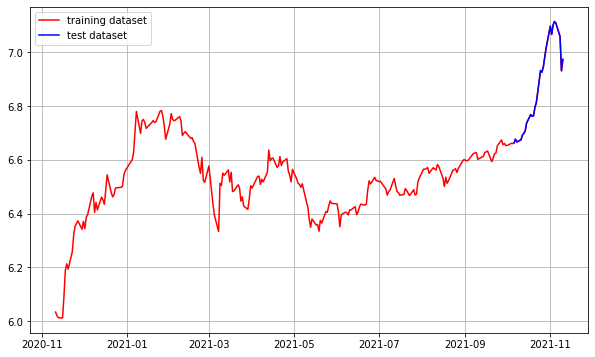

In [79]:
TSLA_train_data, TSLA_test_data = TSLA_ts_log[:int(len(TSLA_ts_log)*0.9)], TSLA_ts_log[int(len(TSLA_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(TSLA_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(TSLA_test_data, c='b', label='test dataset')
plt.legend()

# ARIMA(1, 1, 0)

In [80]:
model = ARIMA(TSLA_train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 442.585
Method:                       css-mle   S.D. of innovations              0.034
Date:                Thu, 11 Nov 2021   AIC                           -879.170
Time:                        06:08:58   BIC                           -868.922
Sample:                             1   HQIC                          -875.034
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0028      0.002      1.309      0.191      -0.001       0.007
ar.L1.D.Close    -0.0588      0.066     -0.885      0.376      -0.189       0.071
                                    Root

# 예측 결과 시각화

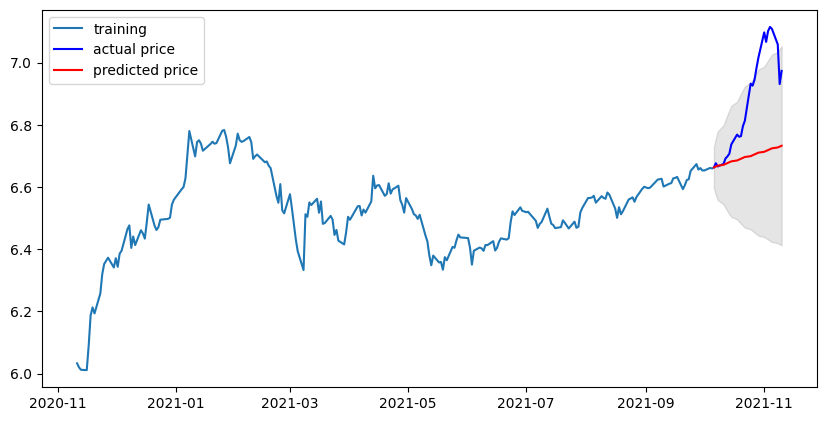

In [81]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(TSLA_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=TSLA_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=TSLA_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=TSLA_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(TSLA_train_data, label='training')
plt.plot(TSLA_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [82]:
mse = mean_squared_error(np.exp(TSLA_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(TSLA_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(TSLA_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(TSLA_test_data))/np.abs(np.exp(TSLA_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  47892.812983420285
MAE:  166.51054025590082
RMSE:  218.8442665079903
MAPE: 15.16%


***

# 5. 엔비디아

# 데이터 불러오기

In [85]:
NVDA_filepath = os.getenv('HOME')+'/aiffel/exp14/stock_prediction/data/NVDA.csv' 
NVDA_df = pd.read_csv(NVDA_filepath) 
NVDA_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-11,130.537506,134.350006,129.482498,134.179993,134.039734,40474400
1,2020-11-12,134.789993,137.660004,133.160004,134.567505,134.426819,36581200
2,2020-11-13,136.272507,136.687500,130.592499,132.970001,132.830994,34631200
3,2020-11-16,131.725006,136.494995,131.559998,135.152496,135.011200,41377600
4,2020-11-17,135.524994,135.962494,133.037506,134.222504,134.082184,31202800


# Date를 인덱스로 설정

In [86]:
NVDA_df = pd.read_csv(NVDA_filepath, index_col='Date', parse_dates=True)
NVDA_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-11,130.537506,134.350006,129.482498,134.179993,134.039734,40474400
2020-11-12,134.789993,137.660004,133.160004,134.567505,134.426819,36581200
2020-11-13,136.272507,136.687500,130.592499,132.970001,132.830994,34631200
2020-11-16,131.725006,136.494995,131.559998,135.152496,135.011200,41377600
2020-11-17,135.524994,135.962494,133.037506,134.222504,134.082184,31202800


# 종가인 Close로 시리즈 생성

In [87]:
NVDA_ts = NVDA_df['Close']
print(type(NVDA_ts))
NVDA_ts.head()

<class 'pandas.core.series.Series'>


Date
2020-11-11    134.179993
2020-11-12    134.567505
2020-11-13    132.970001
2020-11-16    135.152496
2020-11-17    134.222504
Name: Close, dtype: float64

# 결측치 처리

In [88]:
NVDA_ts=NVDA_ts.interpolate(method='time')
NVDA_ts[NVDA_ts.isna()]

Series([], Name: Close, dtype: float64)

# 주가 확인

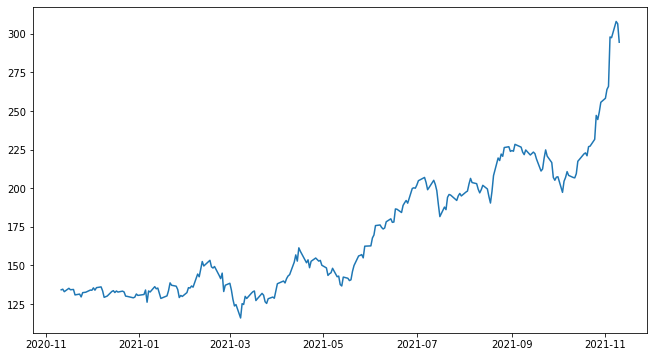

In [89]:
plt.plot(NVDA_ts)

# 로그 처리

In [90]:
NVDA_ts_log = np.log(NVDA_ts)

# 원본시계열, 이동평균, 이동표준편차 시각화

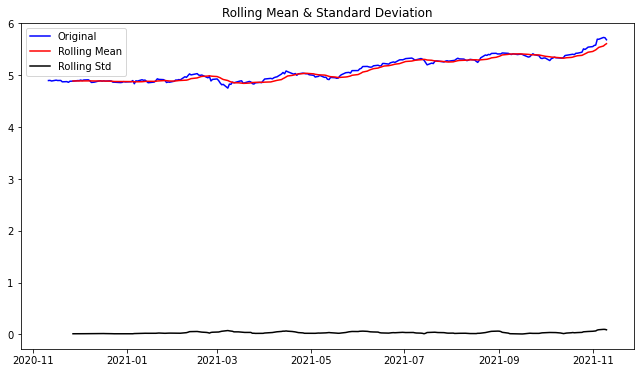

In [91]:
plot_rolling_statistics(NVDA_ts_log, window=12)

# 데이터 정상성 확인

In [92]:
augmented_dickey_fuller_test(NVDA_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   0.697470
p-value                          0.989787
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


# 시계열 분해

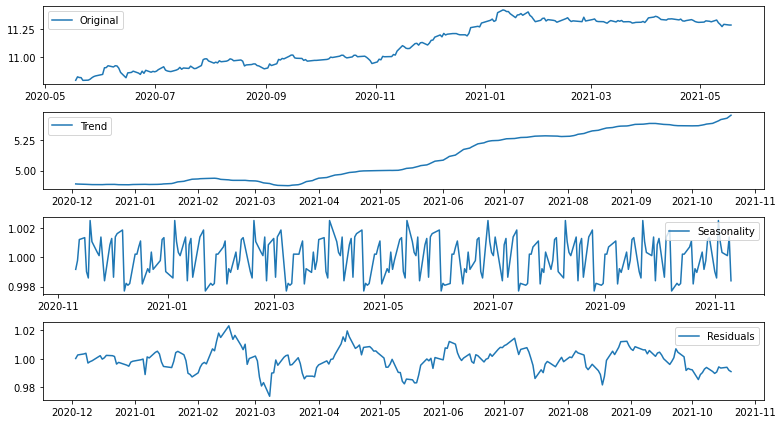

In [93]:
decomposition = seasonal_decompose(NVDA_ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(NVDA_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인

In [94]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.606730
p-value                          0.000126
#Lags Used                       2.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


# ACF 및 PACF 시각화

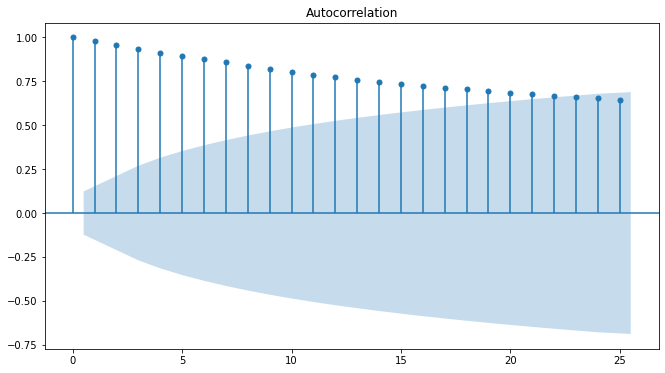

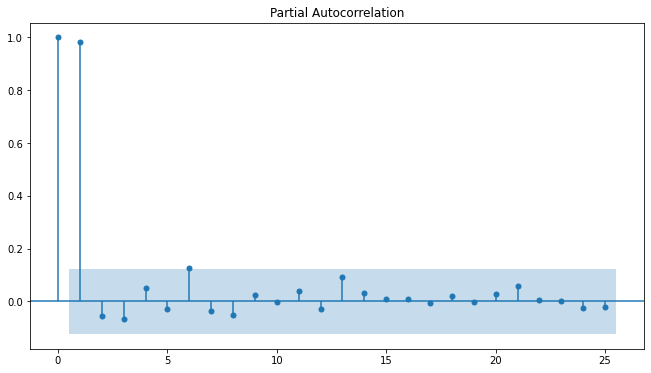

In [95]:
plot_acf(NVDA_ts_log)
plot_pacf(NVDA_ts_log)
plt.show()

# p = 1, q = 0

# 차분

Results of Dickey-Fuller Test:
Test Statistic                -1.638620e+01
p-value                        2.721563e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


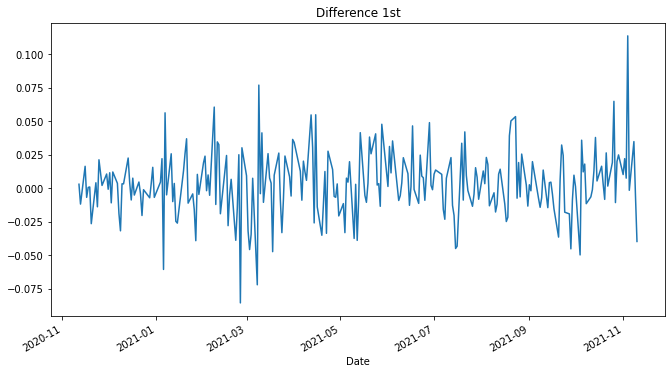

In [96]:
diff_1 = NVDA_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.188335e+01
p-value                        6.104102e-22
#Lags Used                     5.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


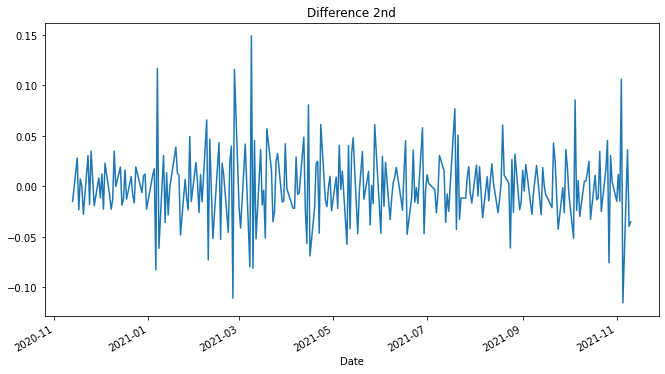

In [97]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# d = 1

# 학습 데이터와 테스트 데이터 분리

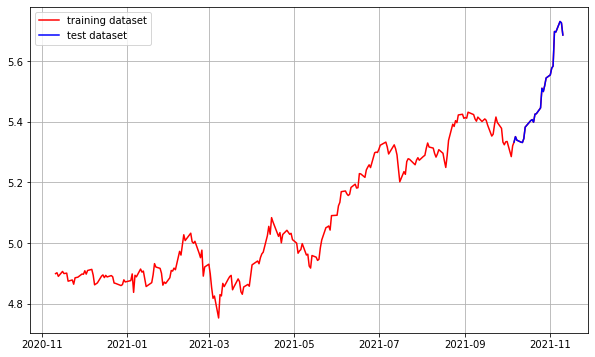

In [98]:
NVDA_train_data, NVDA_test_data = NVDA_ts_log[:int(len(NVDA_ts_log)*0.9)], NVDA_ts_log[int(len(NVDA_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(NVDA_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(NVDA_test_data, c='b', label='test dataset')
plt.legend()

# ARIMA(1, 1, 0)

In [99]:
model = ARIMA(NVDA_train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 519.923
Method:                       css-mle   S.D. of innovations              0.024
Date:                Thu, 11 Nov 2021   AIC                          -1033.846
Time:                        06:14:00   BIC                          -1023.598
Sample:                             1   HQIC                         -1029.710
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.002      1.239      0.215      -0.001       0.005
ar.L1.D.Close    -0.0643      0.067     -0.964      0.335      -0.195       0.066
                                    Root

# 예측 결과 시각화

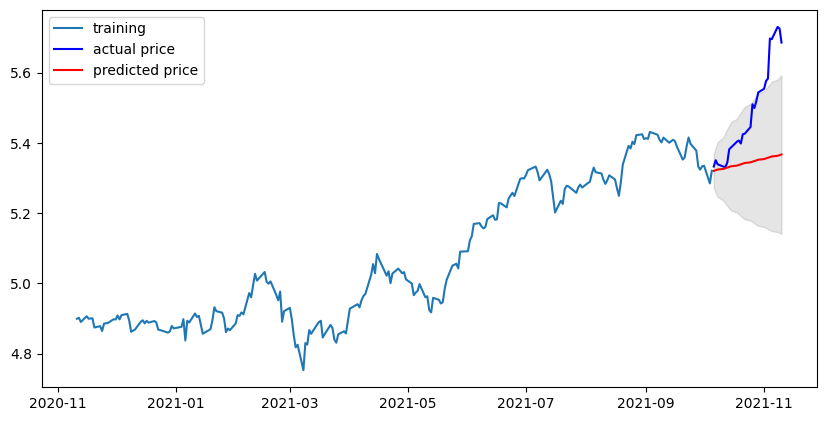

In [100]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(NVDA_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=NVDA_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=NVDA_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=NVDA_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(NVDA_train_data, label='training')
plt.plot(NVDA_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [101]:
mse = mean_squared_error(np.exp(NVDA_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(NVDA_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(NVDA_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(NVDA_test_data))/np.abs(np.exp(NVDA_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2090.725050042046
MAE:  34.03253430679963
RMSE:  45.724446962670264
MAPE: 12.62%


***

# 6. 뱅크오브아메리카

# 데이터 불러오기

In [102]:
BAC_filepath = os.getenv('HOME')+'/aiffel/exp14/stock_prediction/data/BAC.csv' 
BAC_df = pd.read_csv(BAC_filepath) 
BAC_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-11,27.750000,27.770000,27.120001,27.340000,26.785770,48360900
1,2020-11-12,26.840000,26.900000,26.309999,26.690001,26.148949,67912600
2,2020-11-13,26.879999,27.209999,26.760000,27.000000,26.452663,52421000
3,2020-11-16,27.860001,28.000000,27.180000,27.580000,27.020906,57396700
4,2020-11-17,27.250000,27.600000,27.010000,27.549999,26.991514,46402300


# Date를 인덱스로 설정

In [103]:
BAC_df = pd.read_csv(BAC_filepath, index_col='Date', parse_dates=True)
BAC_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-11,27.750000,27.770000,27.120001,27.340000,26.785770,48360900
2020-11-12,26.840000,26.900000,26.309999,26.690001,26.148949,67912600
2020-11-13,26.879999,27.209999,26.760000,27.000000,26.452663,52421000
2020-11-16,27.860001,28.000000,27.180000,27.580000,27.020906,57396700
2020-11-17,27.250000,27.600000,27.010000,27.549999,26.991514,46402300


# 종가인 Close로 시리즈 생성

In [104]:
BAC_ts = BAC_df['Close']
print(type(BAC_ts))
BAC_ts.head()

<class 'pandas.core.series.Series'>


Date
2020-11-11    27.340000
2020-11-12    26.690001
2020-11-13    27.000000
2020-11-16    27.580000
2020-11-17    27.549999
Name: Close, dtype: float64

# 결측치 처리

In [105]:
BAC_ts=BAC_ts.interpolate(method='time')
BAC_ts[BAC_ts.isna()]

Series([], Name: Close, dtype: float64)

# 주가 확인

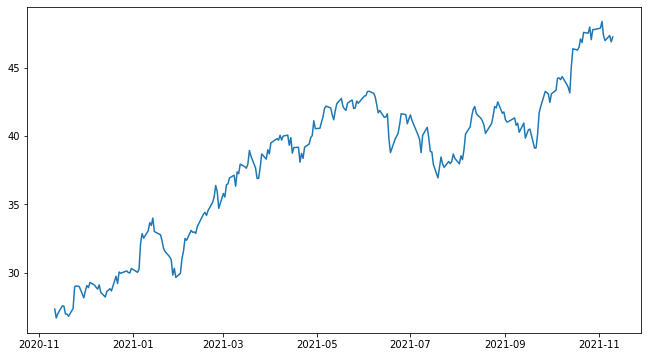

In [106]:
plt.plot(BAC_ts)

# 로그 처리

In [107]:
BAC_ts_log = np.log(BAC_ts)

# 원본시계열, 이동평균, 이동표준편차 시각화

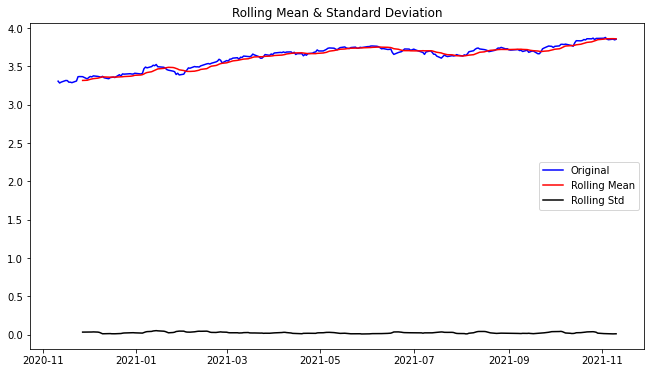

In [108]:
plot_rolling_statistics(BAC_ts_log, window=12)

# 데이터 정상성 확인

In [109]:
augmented_dickey_fuller_test(BAC_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.542560
p-value                          0.512363
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


# 시계열 분해

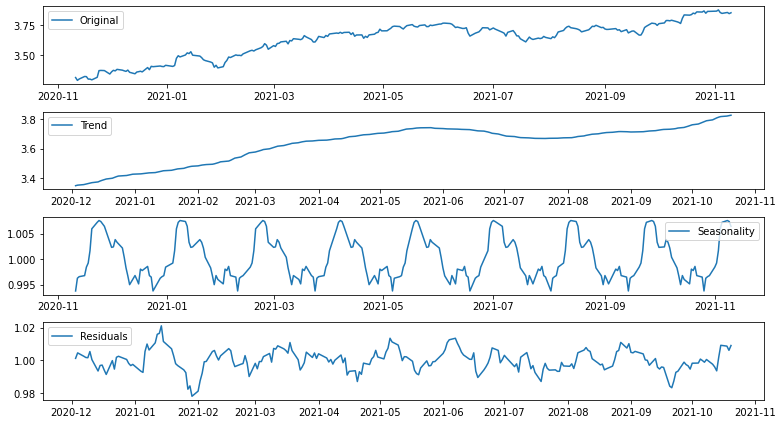

In [112]:
decomposition = seasonal_decompose(BAC_ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(BAC_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인

In [113]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.166142e+00
p-value                        6.982570e-08
#Lags Used                     7.000000e+00
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64


# ACF 및 PACF 시각화

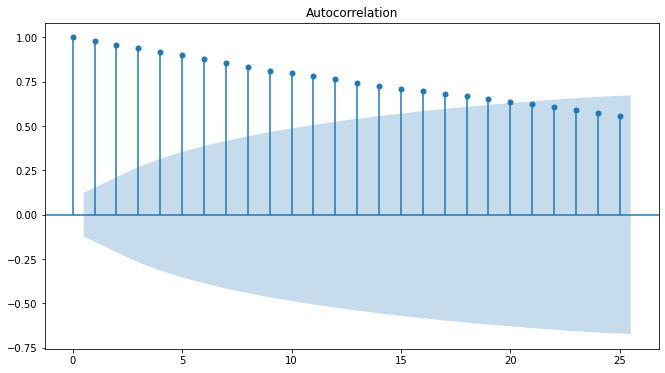

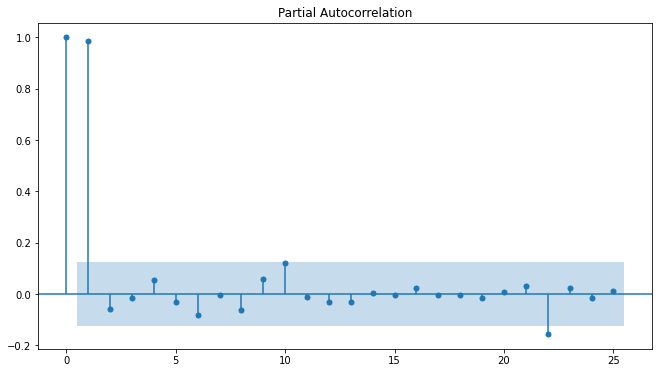

In [114]:
plot_acf(BAC_ts_log)
plot_pacf(BAC_ts_log)
plt.show()

# p = 1, q = 0

# 차분

Results of Dickey-Fuller Test:
Test Statistic                -1.558598e+01
p-value                        1.906345e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


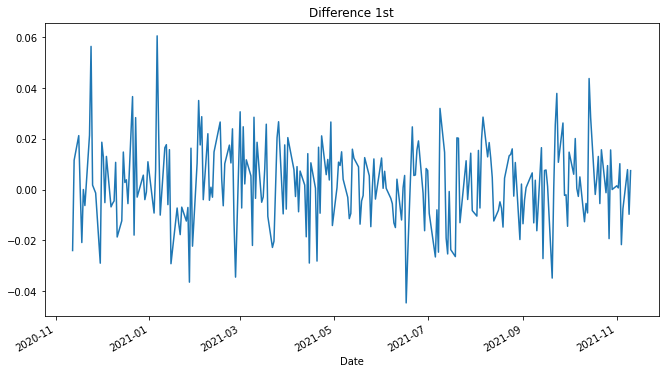

In [115]:
diff_1 = BAC_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.679909e+00
p-value                        4.368730e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


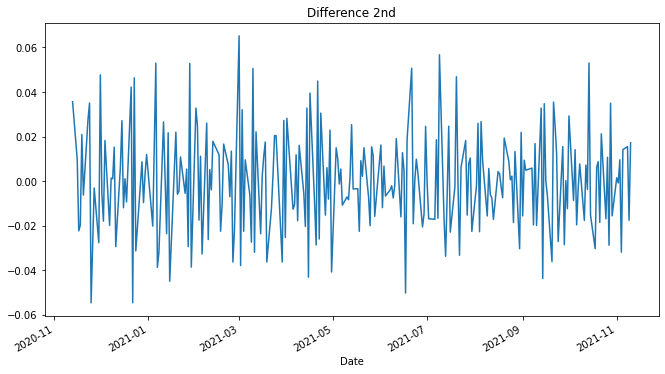

In [116]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# d = 1

# 학습 데이터와 테스트 데이터 분리

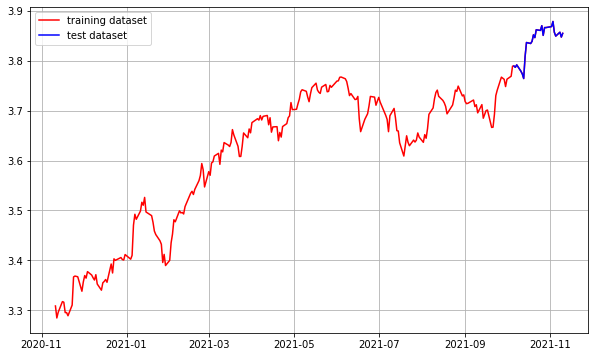

In [117]:
BAC_train_data, BAC_test_data = BAC_ts_log[:int(len(BAC_ts_log)*0.9)], BAC_ts_log[int(len(BAC_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(BAC_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(BAC_test_data, c='b', label='test dataset')
plt.legend()

# ARIMA(1, 1, 0)

In [118]:
model = ARIMA(BAC_train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 604.781
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 11 Nov 2021   AIC                          -1203.562
Time:                        06:24:42   BIC                          -1193.313
Sample:                             1   HQIC                         -1199.425
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0021      0.001      1.906      0.057   -5.99e-05       0.004
ar.L1.D.Close     0.0208      0.067      0.310      0.756      -0.111       0.152
                                    Root

# 예측 결과 시각화

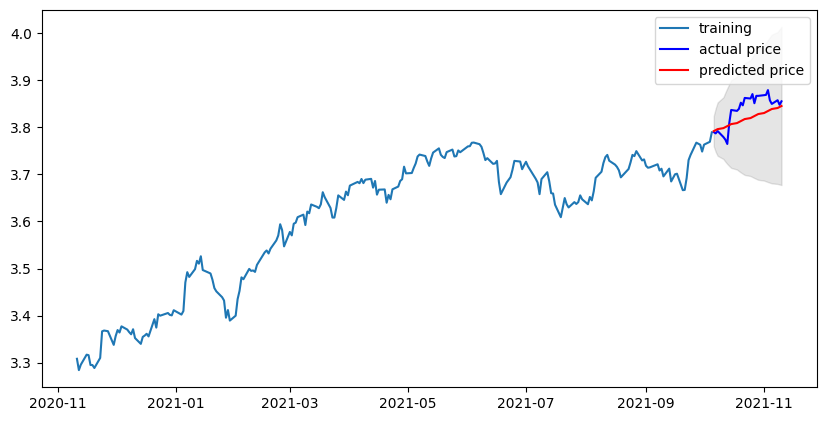

In [119]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(BAC_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=BAC_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=BAC_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=BAC_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(BAC_train_data, label='training')
plt.plot(BAC_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [120]:
mse = mean_squared_error(np.exp(BAC_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(BAC_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(BAC_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(BAC_test_data))/np.abs(np.exp(BAC_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.910389287725662
MAE:  1.204479971926502
RMSE:  1.382168328289164
MAPE: 2.57%


***

# 7. 스퀘어

# 데이터 불러오기

In [121]:
SQ_filepath = os.getenv('HOME')+'/aiffel/exp14/stock_prediction/data/SQ.csv' 
SQ_df = pd.read_csv(SQ_filepath) 
SQ_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-11,179.649994,184.000000,177.699997,183.419998,183.419998,9040800
1,2020-11-12,184.259995,185.190002,177.000000,178.509995,178.509995,9138900
2,2020-11-13,180.600006,180.899994,175.500000,177.190002,177.190002,6955400
3,2020-11-16,175.830002,179.220001,173.009995,179.160004,179.160004,7428200
4,2020-11-17,180.119995,190.740005,180.119995,187.899994,187.899994,11140700


# Date를 인덱스로 설정

In [122]:
SQ_df = pd.read_csv(SQ_filepath, index_col='Date', parse_dates=True)
SQ_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-11,179.649994,184.000000,177.699997,183.419998,183.419998,9040800
2020-11-12,184.259995,185.190002,177.000000,178.509995,178.509995,9138900
2020-11-13,180.600006,180.899994,175.500000,177.190002,177.190002,6955400
2020-11-16,175.830002,179.220001,173.009995,179.160004,179.160004,7428200
2020-11-17,180.119995,190.740005,180.119995,187.899994,187.899994,11140700


# 종가인 Close로 시리즈 생성

In [123]:
SQ_ts = SQ_df['Close']
print(type(SQ_ts))
SQ_ts.head()

<class 'pandas.core.series.Series'>


Date
2020-11-11    183.419998
2020-11-12    178.509995
2020-11-13    177.190002
2020-11-16    179.160004
2020-11-17    187.899994
Name: Close, dtype: float64

# 결측치 처리

In [124]:
SQ_ts=SQ_ts.interpolate(method='time')
SQ_ts[SQ_ts.isna()]

Series([], Name: Close, dtype: float64)

# 주가 확인

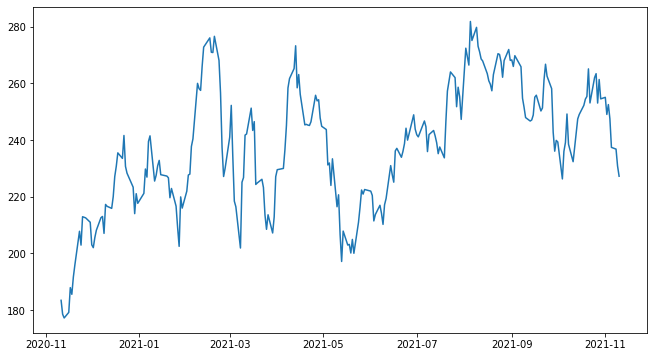

In [125]:
plt.plot(SQ_ts)

# 로그 처리

In [126]:
SQ_ts_log = np.log(SQ_ts)

# 원본시계열, 이동평균, 이동표준편차 시각화

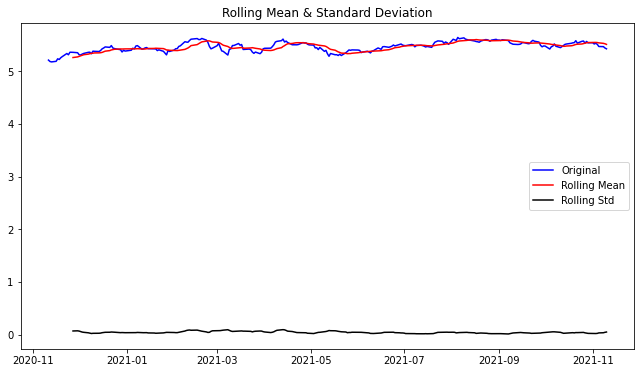

In [127]:
plot_rolling_statistics(SQ_ts_log, window=12)

# 데이터 정상성 확인

In [128]:
augmented_dickey_fuller_test(SQ_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -3.334667
p-value                          0.013398
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


# 시계열 분해

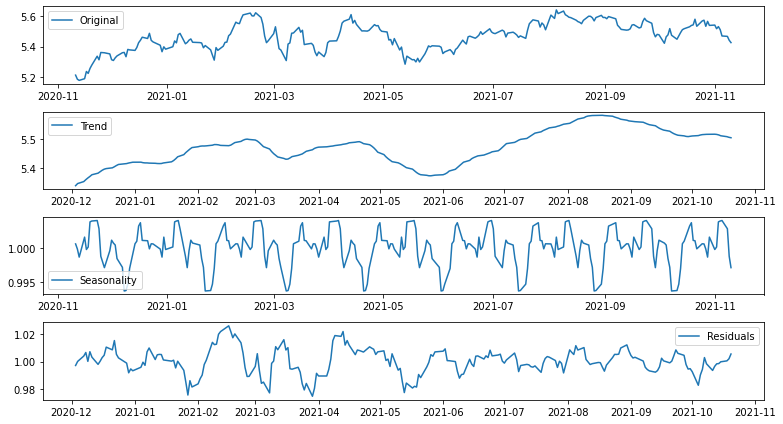

In [129]:
decomposition = seasonal_decompose(SQ_ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(SQ_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인

In [130]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.133117e+00
p-value                        8.309524e-08
#Lags Used                     5.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


# ACF 및 PACF 시각화

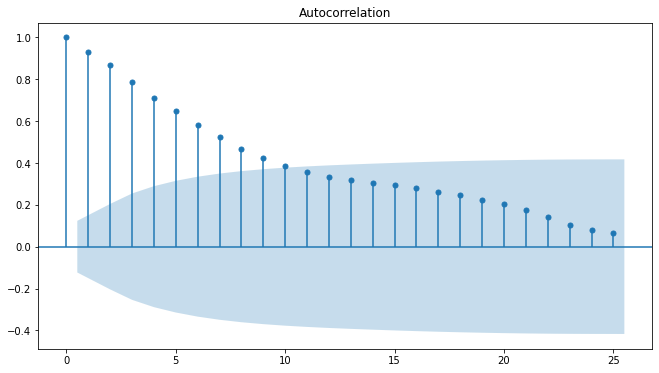

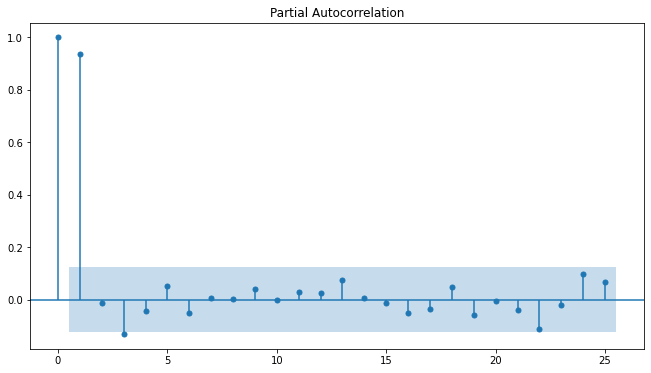

In [131]:
plot_acf(SQ_ts_log)
plot_pacf(SQ_ts_log)
plt.show()

# p = 1, q = 0

# 차분

Results of Dickey-Fuller Test:
Test Statistic                -1.667285e+01
p-value                        1.539652e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


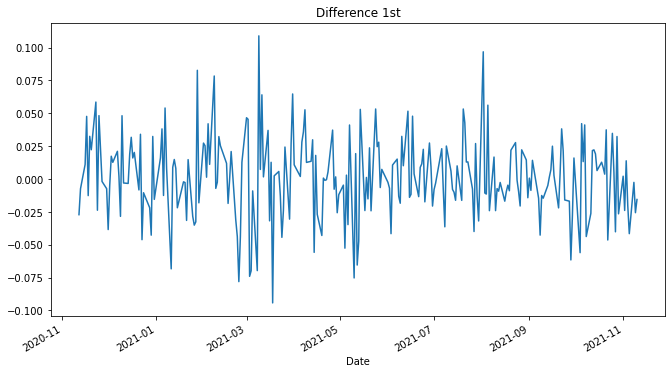

In [132]:
diff_1 = SQ_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.617724e+00
p-value                        2.169343e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


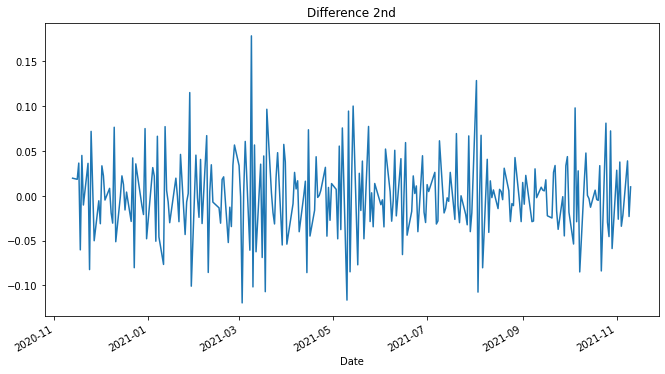

In [133]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# d = 1

# 학습 데이터와 테스트 데이터 분리

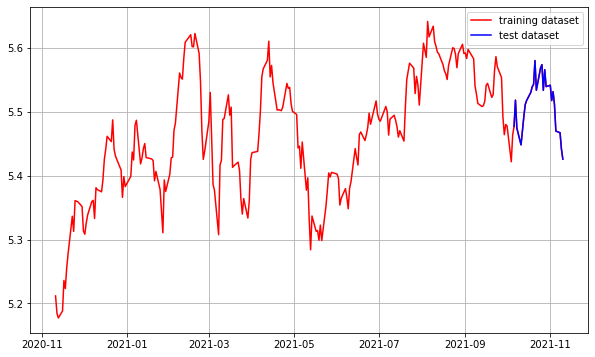

In [134]:
SQ_train_data, SQ_test_data = SQ_ts_log[:int(len(SQ_ts_log)*0.9)], SQ_ts_log[int(len(SQ_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(SQ_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(SQ_test_data, c='b', label='test dataset')
plt.legend()

# ARIMA(1, 1, 0)

In [135]:
model = ARIMA(SQ_train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 457.728
Method:                       css-mle   S.D. of innovations              0.032
Date:                Thu, 11 Nov 2021   AIC                           -909.456
Time:                        06:27:53   BIC                           -899.208
Sample:                             1   HQIC                          -905.320
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.002      0.553      0.580      -0.003       0.005
ar.L1.D.Close    -0.0451      0.067     -0.674      0.500      -0.176       0.086
                                    Root

# 예측 결과 시각화

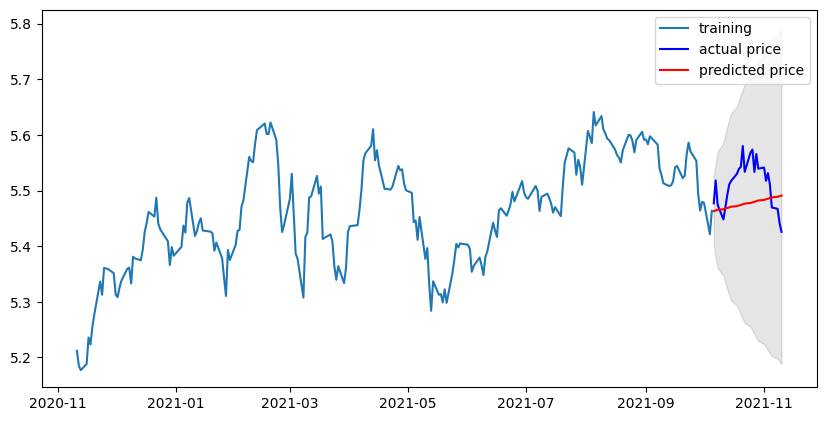

In [136]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(SQ_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=SQ_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=SQ_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=SQ_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(SQ_train_data, label='training')
plt.plot(SQ_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [137]:
mse = mean_squared_error(np.exp(SQ_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(SQ_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(SQ_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(SQ_test_data))/np.abs(np.exp(SQ_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  187.1632385459704
MAE:  11.895795447982257
RMSE:  13.680761621560782
MAPE: 4.72%


***

# MAPE
1. 삼성전자 : 4.68%
2. 애플 : 3.45%
3. 마이크로소프트 : 1.12% 
4. 테슬라 : 15.16%
5. 엔비디아 : 12.62%
6. 뱅크오브아메리카 : 2.57%
7. 스퀘어 : 4.72%

***

# 고찰
ARIMA를 활용한 주가 예측은 변동성을 반영하지 못 하고 일종의 추세 예측 수준에서 이루어지는 것으로 보인다.  
따라서 급격한 변화가 일어난 주식들에서 MAPE의 상승이 관찰되었다.  
주가가 안정적인 주식일수록 MAPE가 낮은 것을 확인할 수 있다.  
이를 통해 MAPE가 낮은 주식을 우량주라고 판단할 수 있을 것이다.  
물론 스퀘어처럼 변동성이 크더라도 변동의 폭이 일정하다면 변동성에 비해 MAPE가 낮게 나오기 때문에 주의가 필요하다.